In [1]:
import os
import nltk
nltk.download('punkt_tab')
import gensim
import smart_open
import numpy as np
import pandas as pd
from gensim.models import Doc2Vec

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jairo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv('items_titles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


In [3]:
df_test = pd.read_csv('items_titles_test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  10000 non-null  object
dtypes: object(1)
memory usage: 78.3+ KB


In [4]:
df.head(5)

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


In [5]:
df_test.head(5)

,ITE_ITEM_TITLE
0,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,Tênis Usthemp Slip-on Temático - Labrador 2
3,Tênis Casual Feminino Moleca Tecido Tie Dye
4,Tênis Star Baby Sapatinho Conforto + Brinde


In [6]:
def cleaning(df):
    df_clean = pd.DataFrame()
    df_clean['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE']
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[àâáã]','a', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[èêé]','e', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[ìí]','i', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[òôõó]','o', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[ùú]','u', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[ç]','s', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.replace(r'[^a-zA-Z0-9 ]','', regex=True)
    df_clean['ITE_ITEM_TITLE'] = df_clean['ITE_ITEM_TITLE'].str.lower()
    return df_clean

In [7]:
df_clean = cleaning(df)
df_clean.to_csv('clean_items_titles.csv',header=False)
df_clean.head(5)

,ITE_ITEM_TITLE
0,tenis ascension posh masculino preto e vermelho
1,tenis para caminhada super levinho spider corr...
2,tenis feminino le parc hocks blackice original...
3,tenis olympikus esportivo academia nova tenden...
4,inteligente led bicicleta tauda luz usb bicicl...


In [8]:
df_clean_test = cleaning(df_test)
df_clean_test.to_csv('clean_items_titles_test.csv',header=False)
df_clean_test.head(5)

,ITE_ITEM_TITLE
0,tenis olympikus esporte valente masculino kids
1,bicicleta barra forte samy c 6 marchas cubo c ...
2,tenis usthemp slipon tematico labrador 2
3,tenis casual feminino moleca tecido tie dye
4,tenis star baby sapatinho conforto brinde


In [9]:
root = os.getcwd()
train_file = root + '/clean_items_titles.csv'
test_file = root + '/clean_items_titles_test.csv'
train_file = train_file.replace("\\", "/")
test_file = test_file.replace("\\", "/")

In [10]:
def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="UTF-8") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(train_file))
test_corpus = list(read_corpus(test_file))

In [12]:
print(train_corpus[0])

TaggedDocument<['tenis', 'ascension', 'posh', 'masculino', 'preto', 'vermelho'], [0]>


In [13]:
print(test_corpus[0])

TaggedDocument<['tenis', 'olympikus', 'esporte', 'valente', 'masculino', 'kids'], [0]>


In [14]:
n_dim = 50
model = gensim.models.doc2vec.Doc2Vec(train_corpus,vector_size=n_dim, min_count=5, epochs=10)
model.build_vocab(train_corpus)

In [15]:
coordinates = np.zeros((len(test_corpus), n_dim))
for doc_id_1 in range(len(test_corpus)):
    coordinates[doc_id_1,] = model.infer_vector(test_corpus[doc_id_1].words)

In [16]:
norms = np.sqrt((coordinates * coordinates).sum(axis=1))
coordinates /= norms[:, np.newaxis]
cosine_similarity = np.dot(coordinates, coordinates.T)
cosine_similarity = (cosine_similarity + 1)/2

In [17]:
results = []
for doc_id_1 in range(len(test_corpus)):
    for doc_id_2 in range(doc_id_1,len(test_corpus)):
        entry = [(' ').join(test_corpus[doc_id_1].words),(' ').join(test_corpus[doc_id_2].words), cosine_similarity[doc_id_1,doc_id_2]]
        results.append(entry)

results_df = pd.DataFrame(results,columns=['ITE_ITEM_TITLE','ITE_ITEM_TITLE','Score Similitud (0,1)']).sort_values(by='Score Similitud (0,1)',ascending=False)

In [18]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50005000 entries, 41593849 to 40708680
Data columns (total 3 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ITE_ITEM_TITLE         object 
 1   ITE_ITEM_TITLE         object 
 2   Score Similitud (0,1)  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ GB


In [19]:
results_df.to_csv('result_items_titles_test.csv',index=False)

In [28]:
import time

times_similarity = np.zeros(10)
times_deliverable = np.zeros(10)

for i in range(10):
    print(i*10)
    start_time = time.time()
    test_corpus_time = test_corpus[0:1000*i]
    coordinates_time = np.zeros((len(test_corpus_time), n_dim))
    for doc_id_1 in range(len(test_corpus_time)):
        coordinates_time[doc_id_1,] = model.infer_vector(test_corpus_time[doc_id_1].words)
        
    norms_time = np.sqrt((coordinates_time * coordinates_time).sum(axis=1))
    coordinates_time /= norms_time[:, np.newaxis]
    cosine_similarity_time = np.dot(coordinates_time, coordinates_time.T)
    cosine_similarity_time = (cosine_similarity_time + 1)/2

    times_similarity[i] = time.time() - start_time
    
    results_time = []
    for doc_id_1 in range(len(test_corpus_time)):
        for doc_id_2 in range(doc_id_1,len(test_corpus_time)):
            entry_time = [(' ').join(test_corpus_time[doc_id_1].words),(' ').join(test_corpus_time[doc_id_2].words), cosine_similarity_time[doc_id_1,doc_id_2]]
            results_time.append(entry_time)
    results_time_df = pd.DataFrame(results_time,columns=['ITE_ITEM_TITLE','ITE_ITEM_TITLE','Score Similitud (0,1)']).sort_values(by='Score Similitud (0,1)',ascending=False)
    results_time_df.to_csv('result_items_titles_test_time.csv',index=False)
    
    times_deliverable[i] = time.time() - start_time

0
10
20
30
40
50
60
70
80
90


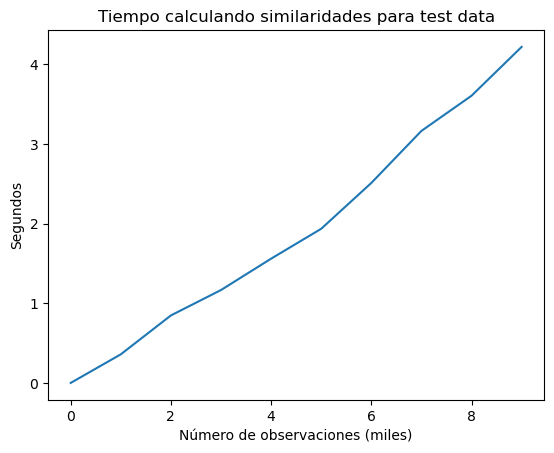

In [30]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 10), times_similarity,label = "Similaridad")

plt.title("Tiempo calculando similaridades para test data")
plt.xlabel("Número de observaciones (miles)")
plt.ylabel("Segundos")

plt.show()

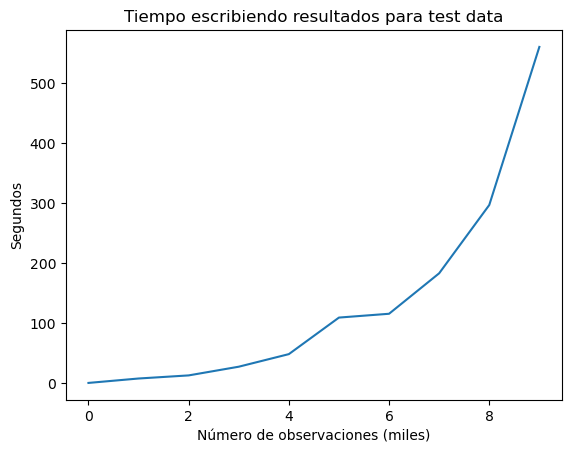

In [33]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 10), times_deliverable, label = "Formato")

plt.title("Tiempo escribiendo resultados para test data")
plt.xlabel("Número de observaciones (miles)")
plt.ylabel("Segundos")

plt.show()